# Prediction of COVID-19 around the world

Student: Angela Amador

TMU Student Number: 500259095

Supervisor: Tamer Abdou, PhD


I aim to demonstrate how Machine Learning (ML) models were able to predict the spread of COVID-19 around the world.

First, I will explore the dataset to get insides and better understand patterns, detect error and outliers, and find relationships between variables. 


## Preparation
Describing the working dataset and any imposed constraints

This dataset is taken from Our World in Data website, officially collected by Our World in Data team: https://covid.ourworldindata.org/data/owid-covid-data.csv.

This dataset will be synced daily. For more info: https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset

In [123]:
# Import libraries
import pandas as pd
from ydata_profiling import ProfileReport
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from sklearn.feature_selection import VarianceThreshold

import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix



### Load file and explore data

The dataset, provided by Our World in Data, provides COVID-19 information collected by Our World in Data available to Kaggle community https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset/download?datasetVersionNumber=418. This dataset is updated daily, for the purpose of this study I am analyzing the data with information up to Oct 7th, 2023.

In [124]:
# Load file
covid_data = pd.read_csv('archive.zip', sep=',')  

#Explore data
covid_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


### Check the data type and metadata of the attributes

In [125]:
covid_data.dtypes

iso_code                                       object
continent                                      object
location                                       object
date                                           object
total_cases                                   float64
new_cases                                     float64
new_cases_smoothed                            float64
total_deaths                                  float64
new_deaths                                    float64
new_deaths_smoothed                           float64
total_cases_per_million                       float64
new_cases_per_million                         float64
new_cases_smoothed_per_million                float64
total_deaths_per_million                      float64
new_deaths_per_million                        float64
new_deaths_smoothed_per_million               float64
reproduction_rate                             float64
icu_patients                                  float64
icu_patients_per_million    

In [126]:
# look at meta information about data, such as null values
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346567 entries, 0 to 346566
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    346567 non-null  object 
 1   continent                                   330089 non-null  object 
 2   location                                    346567 non-null  object 
 3   date                                        346567 non-null  object 
 4   total_cases                                 308672 non-null  float64
 5   new_cases                                   337028 non-null  float64
 6   new_cases_smoothed                          335769 non-null  float64
 7   total_deaths                                287169 non-null  float64
 8   new_deaths                                  337072 non-null  float64
 9   new_deaths_smoothed                         335842 non-null  float64
 

In [127]:
# Let's see meta information about numeric data, we can also see if there any extreme values
covid_data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,3.086720e+05,3.370280e+05,3.357690e+05,2.871690e+05,337072.000000,335842.000000,308672.000000,337028.000000,335769.000000,287169.000000,...,198833.000000,131627.000000,237221.000000,318823.000000,260466.000000,3.465670e+05,1.195300e+04,11953.000000,11953.000000,11953.000000
mean,6.609069e+06,9.695906e+03,9.732069e+03,8.559525e+04,86.392889,86.704207,100634.394008,146.569024,147.113196,867.354640,...,32.909864,50.789455,3.097109,73.714185,0.722460,1.283225e+08,5.113535e+04,9.739424,11.461129,1646.844959
std,4.032547e+07,1.108324e+05,9.495414e+04,4.380493e+05,616.815791,561.926045,150292.226515,1169.506821,602.840371,1096.750172,...,13.574185,31.956355,2.548353,7.395560,0.148979,6.603117e+08,1.442796e+05,12.380781,25.354695,1929.159161
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.700000,1.188000,0.100000,53.280000,0.394000,4.700000e+01,-3.772610e+04,-44.230000,-95.920000,-2752.924800
25%,7.988750e+03,0.000000e+00,2.860000e-01,1.250000e+02,0.000000,0.000000,2573.783500,0.000000,0.056000,59.672000,...,22.600000,20.859000,1.300000,69.590000,0.602000,4.490020e+05,1.066000e+02,1.320000,-1.620000,65.345720
50%,6.904700e+04,2.000000e+00,2.585700e+01,1.313000e+03,0.000000,0.143000,27720.494000,0.169000,6.815000,374.322000,...,33.100000,49.839000,2.500000,75.050000,0.740000,5.882259e+06,5.736601e+03,8.070000,5.770000,1072.472700
75%,7.345502e+05,2.730000e+02,5.107140e+02,1.181800e+04,3.000000,5.286000,131483.602000,36.566000,84.076000,1356.019000,...,41.300000,82.502000,4.200000,79.460000,0.829000,2.830170e+07,3.668959e+04,15.470000,16.520000,2704.933800
max,7.711505e+08,8.401961e+06,6.402036e+06,6.960770e+06,27939.000000,14821.857000,737554.506000,228872.025000,37241.781000,6511.209000,...,78.100000,100.000000,13.800000,86.750000,0.957000,7.975105e+09,1.289776e+06,76.550000,377.630000,10292.916000


### Removing data before COVID vaccinate availability

Multiple vaccinates became available on the second semester of 2020. By December most contries have approved vaccinates for their own country. 

To avoid ..xxxxxx... we will remove data before Jan 1st, 2021 to consider data only with vaccinate availability

In [128]:
print("Original dataset:")
print("Total number of observations: ", covid_data.shape[0])
print("Total number of attributes: ", covid_data.shape[1])
print("Size: ", covid_data.size)


covid_data = covid_data.drop(covid_data[covid_data.date < '2021-01-01'].index)

print("\nAfter removing data before vaccinate was available around the world (Jan 1st, 2021):")
print("Total number of observations: ", covid_data.shape[0])
print("Total number of attributes: ", covid_data.shape[1])
print("Size: ", covid_data.size)


Original dataset:
Total number of observations:  346567
Total number of attributes:  67
Size:  23219989

After removing data before vaccinate was available around the world (Jan 1st, 2021):
Total number of observations:  255173
Total number of attributes:  67
Size:  17096591


## Categorical attributes

Base of the analysis of the attributes iso_code and location, I can tell that one can be derive from the other. For the purpose of this study, I am going to keep location and remove iso_code

In [129]:
# import pickle
# with open("data.pickle", "wb") as output:
#     pickle.dump(covid_data, output, pickle.HIGHEST_PROTOCOL)

# with open("data.pickle", "rb") as input:
#     data = pickle.load(input)

covid_data.groupby(["iso_code"])["iso_code"].count()
covid_data.groupby(["location"])["location"].count()

covid_data = covid_data.drop(['iso_code'], axis=1)

print("\nAfter removing attribute iso_code because it can be delivered from location:")
print("Total number of observations: ", covid_data.shape[0])
print("Total number of attributes: ", covid_data.shape[1])
print("Size: ", covid_data.size)

iso_code
ABW         1009
AFG         1007
AGO         1007
AIA         1007
ALB         1007
AND         1007
ARE         1007
ARG         1009
ARM         1007
ASM         1007
ATG         1007
AUS         1008
AUT         1007
AZE         1007
BDI         1007
BEL         1007
BEN         1007
BES         1007
BFA         1007
BGD         1010
BGR         1010
BHR         1007
BHS         1007
BIH         1007
BLM         1007
BLR         1007
BLZ         1007
BMU         1007
BOL         1007
BRA         1007
BRB         1007
BRN         1007
BTN         1007
BWA         1007
CAF         1007
CAN         1007
CHE         1007
CHL         1007
CHN         1007
CIV         1007
CMR         1007
COD         1007
COG         1007
COK         1007
COL         1007
COM         1007
CPV         1007
CRI         1007
CUB         1007
CUW         1007
CYM         1007
CYP         1007
CZE         1010
DEU         1007
DJI         1007
DMA         1007
DNK         1007
DOM         1007
DZA  

location
Afghanistan                         1007
Africa                              1007
Albania                             1007
Algeria                             1007
American Samoa                      1007
Andorra                             1007
Angola                              1007
Anguilla                            1007
Antigua and Barbuda                 1007
Argentina                           1009
Armenia                             1007
Aruba                               1009
Asia                                1010
Australia                           1008
Austria                             1007
Azerbaijan                          1007
Bahamas                             1007
Bahrain                             1007
Bangladesh                          1010
Barbados                            1007
Belarus                             1007
Belgium                             1007
Belize                              1007
Benin                               1007
Bermuda


After removing attribute iso_code because it can be delivered from location:
Total number of observations:  255173
Total number of attributes:  66
Size:  16841418


# Dimensional Reduction (CMTH642 - Module 9)

Due to the size of the dataset with 255,173 entries and 67 columns, I am going to apply dimensional reduction to provide better features for statistical learning methods

## 1. Removing data columns with too many NaN values

We can calculate the ratio of missing values using a simple formula. The formula is- the number of missing values in each column divided by the total number of observation. Generally, we can drop variables having a missing value ratio of more than 60% or 70%. For my purpose I am going to use a threashold of 60% missing values and remove those attributes.

In [130]:
# Defining threashold of 60% missing values 
threashold_NaN = 0.60

#Explore data
def describe_nan(df):
    return pd.DataFrame([(i, df[df[i].isna()].shape[0],df[df[i].isna()].shape[0]/df.shape[0]) for i in df.columns], columns=['column', 'nan_counts', 'nan_rate'])

pd.options.display.max_rows = None

#icu=covid_data.icu_patients.value_counts(dropna=False)
#display ("NaN entries for the icu_patients column:", icu[icu.index.isnull()])

print("Attributes with more than 60 percentage of missing values:")

describe_nan(covid_data).sort_values(by="nan_rate", ascending=False).query("nan_rate >= %s"%threashold_NaN)

#((covid_data.isnull() | covid_data.isna()).sum() * 100 / covid_data.index.size).round(2)

Attributes with more than 60 percentage of missing values:


,column,nan_counts,nan_rate
65,excess_mortality_cumulative_per_million,246760,0.967030
64,excess_mortality,246760,0.967030
63,excess_mortality_cumulative,246760,0.967030
62,excess_mortality_cumulative_absolute,246760,0.967030
20,weekly_icu_admissions,246705,0.966815
21,weekly_icu_admissions_per_million,246705,0.966815
23,weekly_hosp_admissions_per_million,237173,0.929460
22,weekly_hosp_admissions,237173,0.929460
17,icu_patients_per_million,226284,0.886787
16,icu_patients,226284,0.886787


In [131]:

my_columns = describe_nan(covid_data).sort_values(by="nan_rate", ascending=False).query("nan_rate < %s"%threashold_NaN)[["column"]]
my_columns = my_columns['column'].to_list() 

#dr1 -> Dimensionality Reduction - 1. Removing data columns with too many missing values
dr1_covid_data = covid_data[my_columns]

print("After removing columns with more than 60 percentage of missing values:\n")
print("Total number of observations: ", dr1_covid_data.shape[0])
print("Total number of attributes: ", dr1_covid_data.shape[1])
print("Size: ", dr1_covid_data.size)
print("\n")
dr1_covid_data.info()

After removing columns with more than 60 percentage of missing values:

Total number of observations:  255173
Total number of attributes:  35
Size:  8931055


<class 'pandas.core.frame.DataFrame'>
Index: 255173 entries, 364 to 346566
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   extreme_poverty                             126910 non-null  float64
 1   stringency_index                            132092 non-null  float64
 2   reproduction_rate                           137489 non-null  float64
 3   male_smokers                                146049 non-null  float64
 4   female_smokers                              148063 non-null  float64
 5   hospital_beds_per_thousand                  174245 non-null  float64
 6   new_people_vaccinated_smoothed              179462 non-null  float64
 7   new_people_vaccinated_smoothed_per_hundred  179462 non-null  f

In [132]:
print("Percentage of NaN values per attribute for the remaining columns:\n")
describe_nan(dr1_covid_data).sort_values(by="nan_rate", ascending=False)

# To manage memory dur to the size of the dataset, I am keeping one version of the dataset and removing any temporary copy
covid_data = dr1_covid_data
del(dr1_covid_data)

Percentage of NaN values per attribute for the remaining columns:



,column,nan_counts,nan_rate
0,extreme_poverty,128263,0.502651
1,stringency_index,123081,0.482343
2,reproduction_rate,117684,0.461193
3,male_smokers,109124,0.427647
4,female_smokers,107110,0.419754
5,hospital_beds_per_thousand,80928,0.317150
6,new_people_vaccinated_smoothed,75711,0.296705
7,new_people_vaccinated_smoothed_per_hundred,75711,0.296705
9,new_vaccinations_smoothed_per_million,75551,0.296078
8,new_vaccinations_smoothed,75551,0.296078


## 2. Low Variance Filter

Another way of measuring how much information a data column has, is to measure its variance. In the limit case where the column cells assume a constant value, the variance would be 0 and the column would be of no help in the discrimination of different groups of data.

The Low Variance Filter node calculates each column variance and removes those columns with a variance value below a given threshold. Notice that the variance can only be calculated for numerical columns, i.e. this dimensionality reduction method applies only to numerical columns. Note, too, that the variance value depends on the column numerical range. Therefore data column ranges need to be normalized to make variance values independent from the column domain range.

First a Normalizer node normalizes all column ranges to [0, 1]; next, a Low Variance Filter node calculates the columns variance and filters out the columns with a variance lower than a set threshold.

In [133]:
# Initialization is just like any other Scikit-learn estimator. The default value for the threshold is always 0. 
# Also, the estimator only works with numeric data obviously and it will raise an error if there are categorical features present in the dataframe. 
# That’s why, for now, I will subset the numeric features into another dataframe:

vt = VarianceThreshold()

#dr2 -> Dimensionality Reduction - 2. Removing low variance filter
dr2_covid_data_num = covid_data.select_dtypes(include="number")
#dr2_covid_data_num.shape
#dr2_covid_data_num.info()


In [134]:
# Before, I need to take care of missing values encoded as NaN natively by replacing with the mean on reduced dataset "dr2_covid_data_reduced"

print ("Before replacing NaN values with the mean:\n")
print("Total number of observations: ", dr2_covid_data_num.shape[0])
print("Total number of attributes: ", dr2_covid_data_num.shape[1])
print("Size: ", dr2_covid_data_num.size)
print("\n")
dr2_covid_data_num.info()

for c in dr2_covid_data_num.columns:
    dr2_covid_data_num[c] = dr2_covid_data_num[c].fillna(dr2_covid_data_num[c].mean())

print ("\nAfter replacing NaN values with the mean:\n")
print("Total number of observations: ", dr2_covid_data_num.shape[0])
print("Total number of attributes: ", dr2_covid_data_num.shape[1])
print("Size: ", dr2_covid_data_num.size)
print("\n")
dr2_covid_data_num.info()

Before replacing NaN values with the mean:

Total number of observations:  255173
Total number of attributes:  32
Size:  8165536


<class 'pandas.core.frame.DataFrame'>
Index: 255173 entries, 364 to 346566
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   extreme_poverty                             126910 non-null  float64
 1   stringency_index                            132092 non-null  float64
 2   reproduction_rate                           137489 non-null  float64
 3   male_smokers                                146049 non-null  float64
 4   female_smokers                              148063 non-null  float64
 5   hospital_beds_per_thousand                  174245 non-null  float64
 6   new_people_vaccinated_smoothed              179462 non-null  float64
 7   new_people_vaccinated_smoothed_per_hundred  179462 non-null  float64
 8   new_vaccinations

In [135]:
# First, we fit the estimator to data and call its get_support() method. It returns a boolean mask with True values for columns which are not dropped. 
# We can then use this mask to subset our DataFrame like so

_ = vt.fit(dr2_covid_data_num)
mask = vt.get_support()

dr2_covid_data_num = dr2_covid_data_num.loc[:, mask]

# dr2_covid_data_num.shape

# dr2_covid_data_num.info()


In [136]:
# We still have the same number of features. Now, let’s drop features with variances close to 0
vt = VarianceThreshold(threshold=1)

# Fit
_ = vt.fit(dr2_covid_data_num)

# # Get the boolean mask
mask = vt.get_support()

dr2_covid_data_reduced = dr2_covid_data_num.loc[:, mask]

print ("\nAfter dropping features with variances close to 0:\n")
print("Total number of observations: ", dr2_covid_data_reduced.shape[0])
print("Total number of attributes: ", dr2_covid_data_reduced.shape[1])
print("Size: ", dr2_covid_data_reduced.size)
print("\n")
dr2_covid_data_reduced.info()

# With a threshold of 1, 3 attributes were removedthreshold
# From: (255173, 32)
# To: (255173, 29)


After dropping features with variances close to 0:

Total number of observations:  255173
Total number of attributes:  29
Size:  7400017


<class 'pandas.core.frame.DataFrame'>
Index: 255173 entries, 364 to 346566
Data columns (total 29 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   extreme_poverty                        255173 non-null  float64
 1   stringency_index                       255173 non-null  float64
 2   male_smokers                           255173 non-null  float64
 3   female_smokers                         255173 non-null  float64
 4   hospital_beds_per_thousand             255173 non-null  float64
 5   new_people_vaccinated_smoothed         255173 non-null  float64
 6   new_vaccinations_smoothed              255173 non-null  float64
 7   new_vaccinations_smoothed_per_million  255173 non-null  float64
 8   aged_65_older                          255173 non-null  f

In [137]:
# The attributes that were dropped are:
# - reproduction_rate
# - new_people_vaccinated_smoothed_per_hundred
# - human_development_index

In [138]:
# Method of normalizing all features by dividing them by their mean

normalized_df = dr2_covid_data_num / dr2_covid_data_num.mean()
normalized_df.head()

print("Variance of the normalized dataset:\n")
normalized_df.var()

,extreme_poverty,stringency_index,reproduction_rate,male_smokers,female_smokers,hospital_beds_per_thousand,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,...,total_cases_per_million,new_cases_per_million,new_cases,new_cases_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,new_deaths_smoothed,new_deaths,new_deaths_per_million,population
364,1.0,0.309718,0.991848,1.0,1.0,0.161439,1.0,1.0,1.0,1.0,...,0.009977,0.024114,0.015494,0.011077,0.017253,0.233626,0.110464,0.141538,0.299663,0.321068
365,1.0,0.309718,0.980315,1.0,1.0,0.161439,1.0,1.0,1.0,1.0,...,0.009990,0.009621,0.006181,0.009919,0.015446,0.223424,0.105438,0.117949,0.249377,0.321068
366,1.0,0.309718,0.980315,1.0,1.0,0.161439,1.0,1.0,1.0,1.0,...,0.010014,0.016211,0.010414,0.010389,0.016182,0.223424,0.105438,0.117949,0.249377,0.321068
367,1.0,0.309718,0.980315,1.0,1.0,0.161439,1.0,1.0,1.0,1.0,...,0.010052,0.026358,0.016933,0.010884,0.016950,0.212202,0.100412,0.106154,0.224747,0.321068
368,1.0,0.309718,0.968782,1.0,1.0,0.161439,1.0,1.0,1.0,1.0,...,0.010071,0.013442,0.008636,0.010426,0.016236,0.194859,0.092047,0.082564,0.174461,0.321068


Variance of the normalized dataset:



extreme_poverty                                 1.047002
stringency_index                                0.163080
reproduction_rate                               0.114146
male_smokers                                    0.097370
female_smokers                                  0.579030
hospital_beds_per_thousand                      0.462300
new_people_vaccinated_smoothed                 36.227829
new_people_vaccinated_smoothed_per_hundred      3.587963
new_vaccinations_smoothed                      29.976837
new_vaccinations_smoothed_per_million           1.823817
human_development_index                         0.031885
aged_65_older                                   0.372831
gdp_per_capita                                  0.860112
cardiovasc_death_rate                           0.161974
aged_70_older                                   0.440998
median_age                                      0.069842
diabetes_prevalence                             0.270828
population_density             

In [139]:
# Now, we can use the estimator with a lower threshold like 0.005
vt = VarianceThreshold(threshold=0.005)

# Fit
_ = vt.fit(normalized_df)

# # Get the boolean mask
mask = vt.get_support()

dr2_covid_data_final = dr2_covid_data_num.loc[:, mask]

dr2_covid_data_final.shape

# With a threshold of 0.05, zero attributes were removed threshold
# From: (255173, 32)
# To: (255173, 32)

(255173, 32)

In [140]:
# dr2_covid_data_reduced.columns.get_loc('total_cases')
# dr2_covid_data_reduced.shape[1]

In [141]:
# With method of normalizing no attributes were removed; while with variances close to 0, 3 features were removed.
# - reproduction_rate
# - new_people_vaccinated_smoothed_per_hundred
# - human_development_index

# I will check if it is rigth to removed these 3 attributes. I will test this by training two RandomForestRegressor to predict a total_cases: the first one on the reduced dataset (dr2_covid_data_reduced), feature selected dataset
# and the second one on the full, numeric-feature only dataset (dr2_covid_data_num).

#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split

# Find out the index of total_cases column
c = dr2_covid_data_reduced.columns.get_loc('total_cases')

# Find out number of columns
d = dr2_covid_data_reduced.shape[1]

# Build feature, target arrays
X, y = dr2_covid_data_reduced.iloc[:, [i for i in range(d) if i != c]], dr2_covid_data_reduced.iloc[:, [c]]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1121218)

# Init, fit, score
forest = RandomForestRegressor(random_state=1121218)

_ = forest.fit(X_train, y_train)

# Training Score
print(f"Training Score: {forest.score(X_train, y_train)}")
#Training Score: 0.988528867222243

print(f"Test Score: {forest.score(X_test, y_test)}")
# Test Score: 0.9511616691995844

print("Both training and test score suggest a really high performance without overfitting.")

Training Score: 0.9999950801210624
Test Score: 0.9999399219055796
Both training and test score suggest a really high performance without overfitting.


In [142]:
# dr2_covid_data_num.columns.get_loc('total_cases')
# dr2_covid_data_num.shape[1]

In [143]:
# Now, let’s train the same model on the full numeric-only dataset

# Find out the index of total_cases column
c = dr2_covid_data_num.columns.get_loc('total_cases')

# Find out number of columns
d = dr2_covid_data_num.shape[1]


# Build feature, target arrays
X, y = dr2_covid_data_num.iloc[:, [i for i in range(d) if i != c]], dr2_covid_data_num.iloc[:, [c]]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1121218)

# Init, fit, score
forest = RandomForestRegressor(random_state=1121218)

_ = forest.fit(X_train, y_train)

# Training Score
print(f"Training Score: {forest.score(X_train, y_train)}")
#Training Score: 0.988528867222243

print(f"Test Score: {forest.score(X_test, y_test)}")

print("I can confirm that there isn't any impact on the prediction by removing these 3 features")

#Freeing memory
del(X)
del(y)
del(X_train)
del(X_test)
del(y_train)
del(y_test)
del(dr2_covid_data_num)
del(dr2_covid_data_reduced)
del(dr2_covid_data_final)
del(normalized_df)

Training Score: 0.9999920034215055
Test Score: 0.9999035126774154
I can confirm that there isn't any impact on the prediction by removing these 3 features


In [144]:
# Droping the columns identified with variance close to 0
# - reproduction_rate
# - new_people_vaccinated_smoothed_per_hundred
# - human_development_index

covid_data = covid_data.drop(['reproduction_rate'], axis=1)
covid_data = covid_data.drop(['new_people_vaccinated_smoothed_per_hundred'], axis=1)
covid_data = covid_data.drop(['human_development_index'], axis=1)
print("After removing columns identified with variance close to 0:\n")
print("Total number of observations: ", covid_data.shape[0])
print("Total number of attributes: ", covid_data.shape[1])
print("Size: ", covid_data.size)
print("\n")
covid_data.info()

After removing columns identified with variance close to 0:

Total number of observations:  255173
Total number of attributes:  32
Size:  8165536


<class 'pandas.core.frame.DataFrame'>
Index: 255173 entries, 364 to 346566
Data columns (total 32 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   extreme_poverty                        126910 non-null  float64
 1   stringency_index                       132092 non-null  float64
 2   male_smokers                           146049 non-null  float64
 3   female_smokers                         148063 non-null  float64
 4   hospital_beds_per_thousand             174245 non-null  float64
 5   new_people_vaccinated_smoothed         179462 non-null  float64
 6   new_vaccinations_smoothed              179622 non-null  float64
 7   new_vaccinations_smoothed_per_million  179622 non-null  float64
 8   aged_65_older                          194141 non

## 3. High correlation with other data columns


* https://www.kaggle.com/code/bbloggsbott/feature-selection-correlation-and-p-value

### Selecting columns based on correlation

,extreme_poverty,stringency_index,male_smokers,female_smokers,hospital_beds_per_thousand,new_people_vaccinated_smoothed,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,aged_65_older,gdp_per_capita,...,new_cases,new_cases_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,new_deaths_smoothed,new_deaths,new_deaths_per_million,location,population,date
extreme_poverty,1.000000,-0.104870,-0.192305,-0.411078,-0.443514,-0.021389,-0.031198,-0.196236,-0.573979,-0.502392,...,-0.027644,-0.030553,-0.171415,-0.210197,-0.039553,-0.037453,-0.111540,0.041243,-0.025284,-1.603214e-04
stringency_index,-0.104870,1.000000,0.063403,-0.092286,-0.020628,0.161439,0.148472,0.331047,-0.006704,0.014314,...,0.024830,0.027412,0.011093,0.274914,0.174567,0.150895,0.152339,0.014137,0.144791,-6.709993e-01
male_smokers,-0.192305,0.063403,1.000000,0.226511,0.347231,0.008857,0.021132,0.016076,0.084377,-0.102326,...,0.008733,0.009748,0.018414,0.078138,0.004446,0.004229,0.041541,0.034503,0.014974,2.357157e-05
female_smokers,-0.411078,-0.092286,0.226511,1.000000,0.473754,-0.046677,-0.051317,0.089861,0.733060,0.309315,...,-0.004214,-0.004692,0.194196,0.236108,-0.007409,-0.007083,0.127345,-0.047569,-0.064247,1.901350e-04
hospital_beds_per_thousand,-0.443514,-0.020628,0.347231,0.473754,1.000000,-0.016451,-0.005088,0.111612,0.602605,0.291044,...,0.017094,0.019100,0.139971,0.145092,0.000627,0.000575,0.078420,0.026951,-0.023034,8.876861e-05
new_people_vaccinated_smoothed,-0.021389,0.161439,0.008857,-0.046677,-0.016451,1.000000,0.926793,0.100686,-0.000340,-0.018018,...,0.244859,0.283370,-0.024371,0.003234,0.669298,0.614991,0.001643,0.031833,0.603048,-1.000845e-01
new_vaccinations_smoothed,-0.031198,0.148472,0.021132,-0.051317,-0.005088,0.926793,1.000000,0.110139,0.007419,-0.016192,...,0.333956,0.386131,-0.019129,-0.003581,0.691898,0.635201,-0.001994,0.035413,0.673488,-8.437316e-02
new_vaccinations_smoothed_per_million,-0.196236,0.331047,0.016076,0.089861,0.111612,0.100686,0.110139,1.000000,0.147935,0.193790,...,0.016114,0.017367,0.096538,0.159707,0.055612,0.050778,0.086719,0.018064,-0.015322,-3.723620e-01
aged_65_older,-0.573979,-0.006704,0.084377,0.733060,0.602605,-0.000340,0.007419,0.147935,1.000000,0.499053,...,0.033324,0.037318,0.271530,0.267082,0.031101,0.029290,0.147166,-0.037126,-0.002307,-2.645612e-04
gdp_per_capita,-0.502392,0.014314,-0.102326,0.309315,0.291044,-0.018018,-0.016192,0.193790,0.499053,1.000000,...,0.015813,0.017735,0.205391,0.103290,0.011131,0.010427,0.055520,0.026129,-0.025976,-4.474758e-03


<Axes: >

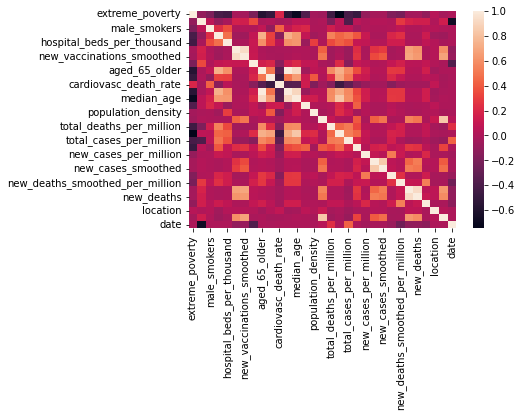

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Dataset copy to be use in the correlation, remove the column total_cases because it is the column we are trying to predict
data = covid_data.drop(['total_cases'], axis=1)

# The numpy.random.seed() makes the random numbers predictable and is used for reproducibility
np.random.seed(123)

# Find out the index for categorical variables
continent = data.columns.get_loc('continent')
location = data.columns.get_loc('location')
date = data.columns.get_loc('date')

# Encode the Categorical Variable
# The dataset has 3 categorical attributes: date, continent and location
# label_encoder = LabelEncoder()
data.iloc[:,continent] = label_encoder.fit_transform(data.iloc[:,continent]).astype('float64')
data.iloc[:,location] = label_encoder.fit_transform(data.iloc[:,location]).astype('float64')
data.iloc[:,date] = label_encoder.fit_transform(data.iloc[:,date]).astype('float64')

# data.head()
# data.tail()

# covid_data.head()
# covid_data.tail()

corr = data.corr()
corr

sns.heatmap(corr)

In [150]:
# Next, compare the correlation between features and remove one of two features that have a correlation higher than 0.9

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = data.columns[columns]
# selected_columns
# selected_columns.shape

## Add total_cases column which is the column to be predicted
total_cases = pd.Index(['total_cases'])
selected_columns = selected_columns.append(total_cases)
selected_columns
selected_columns.shape



Index(['extreme_poverty', 'stringency_index', 'male_smokers', 'female_smokers',
       'hospital_beds_per_thousand', 'new_people_vaccinated_smoothed',
       'new_vaccinations_smoothed_per_million', 'aged_65_older',
       'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'population_density', 'total_deaths', 'total_deaths_per_million',
       'life_expectancy', 'total_cases_per_million', 'continent',
       'new_cases_per_million', 'new_cases', 'new_cases_smoothed',
       'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million',
       'new_deaths_smoothed', 'new_deaths_per_million', 'location',
       'population', 'date', 'total_cases'],
      dtype='object')

(28,)

In [151]:
#Before:
# Total number of observations:  255173
# Total number of attributes:  32
# Size:  8165536

# 27 columns were selected + total_cases (predicted column) from the 32 columns

covid_data = covid_data[selected_columns]

print("After remove one of two features that have a correlation higher than 0.9:\n")
print("Total number of observations: ", covid_data.shape[0])
print("Total number of attributes: ", covid_data.shape[1])
print("Size: ", covid_data.size)
print("\n")
covid_data.info()

# After remove one of two features that have a correlation higher than 0.9:

# Total number of observations:  255173
# Total number of attributes:  28
# Size:  7144844


After remove one of two features that have a correlation higher than 0.9:

Total number of observations:  255173
Total number of attributes:  28
Size:  7144844


<class 'pandas.core.frame.DataFrame'>
Index: 255173 entries, 364 to 346566
Data columns (total 28 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   extreme_poverty                        126910 non-null  float64
 1   stringency_index                       132092 non-null  float64
 2   male_smokers                           146049 non-null  float64
 3   female_smokers                         148063 non-null  float64
 4   hospital_beds_per_thousand             174245 non-null  float64
 5   new_people_vaccinated_smoothed         179462 non-null  float64
 6   new_vaccinations_smoothed_per_million  179622 non-null  float64
 7   aged_65_older                          194141 non-null  float64
 8   gdp_per_capita                     

### Selecting columns based on p-value

Selecting the columns based on how they affect the p-value. 

First I need to remove the column total_cases because it is the column to be predicted

* https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f

# Generate Profiling Report

In [ ]:
# Genetate profiling report
#profile = ProfileReport(covid_data, title="Profiling Report")
#profile = ProfileReport(covid_data, title="Profiling Report", html={'style':{'fullwith':True}})
#profile